In [1]:
# this file is for running the line-fitting models and plot the best-fitting results 
import numpy as np
from astropy.io import fits
import os, sys
# from veremisfitting.line_fitting_exec import *
# from veremisfitting.line_fitting_model import *
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.modeling import models,fitting

import numpy as np
import matplotlib.pyplot as plt
from loess.loess_2d import loess_2d
%matplotlib inline
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd

import astropy.io.fits as pyfits
import astropy.units as u

import sep
import glob
import grizli
from grizli import utils
print(f'grizli version: {grizli.__version__}')

import msaexp
import msaexp.spectrum
print(f'msaexp version: {msaexp.__version__}')

from astropy.table import Table
import astropy.units as u

BASE_URL = 'https://s3.amazonaws.com/msaexp-nirspec/extractions/'
PATH_TO_FILE = BASE_URL + '{root}/{file}'
# define the absolute path of the current working directory
current_direc = os.getcwd() 

fsize = 15
tsize = 15
tdir = 'in'
major = 18.0
minor = 16.0
lwidth = 0.8
lhandle = 2.0
labelpad = 5.5

%matplotlib inline
#%matplotlib qt5
fontsize= 21
tsize = 15
tdir = 'in'
major = 7.0
minor = 4.0
lwidth = 2
lhandle = 2.0
labelpad = 5.5
spiwidth = 2

plt.style.use('default')
#plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = fontsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = major
plt.rcParams['ytick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = major
plt.rcParams['ytick.minor.size'] = minor
plt.rcParams['xtick.major.width'] = lwidth
plt.rcParams['ytick.major.width'] = lwidth
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True


grizli version: 1.12.9
Failed to `import dust_attenuation`
Install from the repo with $ pip install git+https://github.com/karllark/dust_attenuation.git
msaexp version: 0.9.2


In [2]:
def read_results_from_txt(filename):
    """
    Read flux, EW, FWHM results with errors, Gaussian parameters, and Chi-squared values from a text file.

    Parameters:
    - filename: Path to the input text file.
    
    Returns:
    - A dictionary containing all the extracted parameters, including Gaussian parameters and their errors.
    """
    results = {}

    with open(filename, 'r') as f:
        lines = f.readlines()

    # Extract source ID
    results['source_id'] = lines[0].split(":")[1].strip()

    # Find the number of Gaussian components
    for line in lines:
        if line.startswith("Number of Gaussian Components"):
            results['num_gaussians'] = int(line.split(":")[1].strip())
            break
    
    # Extract Gaussian components parameters and errors
    gaussians = []
    current_gaussian = None
    for line in lines:
        if line.startswith("Gaussian"):
            if current_gaussian is not None:
                gaussians.append(current_gaussian)
            current_gaussian = {}
        if line.startswith("  Amplitude"):
            current_gaussian['Amplitude'] = float(line.split('=')[1].split('±')[0].strip())
            current_gaussian['Amplitude_Error'] = float(line.split('±')[1].strip().split()[0])
        elif line.startswith("  Mean (Velocity)"):
            current_gaussian['Mean'] = float(line.split('=')[1].split('±')[0].strip())
            current_gaussian['Mean_Error'] = float(line.split('±')[1].strip().split()[0])
        elif line.startswith("  Stddev (Width)"):
            current_gaussian['Stddev'] = float(line.split('=')[1].split('±')[0].strip())
            current_gaussian['Stddev_Error'] = float(line.split('±')[1].strip().split()[0])
        elif line.startswith("-" * 40):  # End of a Gaussian block
            if current_gaussian is not None:
                gaussians.append(current_gaussian)
                current_gaussian = None

    # remove empty gaussians
    gaussians = [g for g in gaussians if g]
    results['gaussians'] = gaussians
    

    # Extract component results (Flux, EW, FWHM)
    components = []
    current_component = None
    for line in lines:
        if line.startswith("Gaussian"):
            if current_component is not None:
                components.append(current_component)
            current_component = {}
        if line.startswith("  Flux"):
            current_component['Flux'] = float(line.split('=')[1].split('±')[0].strip())
            current_component['Flux_Error'] = float(line.split('±')[1].strip().split()[0])
        elif line.startswith("  EW"):
            current_component['EW'] = float(line.split('=')[1].split('±')[0].strip())
            current_component['EW_Error'] = float(line.split('±')[1].strip().split()[0])
        elif line.startswith("  FWHM"):
            current_component['FWHM'] = float(line.split('=')[1].split('±')[0].strip())
            current_component['FWHM_Error'] = float(line.split('±')[1].strip().split()[0])
        elif line.startswith("  Luminosity"): 
            current_component['Luminosity'] = float(line.split('=')[1].split('±')[0].strip())
            current_component['Luminosity_Error'] = float(line.split('±')[1].strip().split()[0])
        elif line.startswith("-" * 40):  # End of a component block
            if current_component is not None:
                components.append(current_component)
                current_component = None

    # remove empty components
    components = [c for c in components if c]
    results['components'] = components

    # Extract Chi-squared and Reduced Chi-squared values
    for line in lines:
        if line.startswith("Chi-squared"):
            results['chi2'] = float(line.split(":")[1].strip())
        elif line.startswith("Reduced Chi-squared"):
            results['reduced_chi2'] = float(line.split(":")[1].strip())
        elif line.startswith("BIC"):
            results['BIC'] = float(line.split(":")[1].strip())
        elif line.startswith("AIC"):
            results['AIC'] = float(line.split(":")[1].strip())

    return results

In [3]:
my_catalog_file = '../catalog/all_nirspec_beta_withclassify_z2.ecsv'
all_nirspec_beta_catalog = Table.read(my_catalog_file, format='ascii.ecsv')

In [4]:
all_nirspec_beta_catalog[all_nirspec_beta_catalog['uid'] == 18274]

jname,ndup,uid,ra,dec,file,root,srcid,nGr,Grating,grade,zfit,z,comment,References,nRef,sn50,wmin,wmax,Lya,Ha,OIII,L_Ha,L_OIII,HST,NIRCam,slit,FITS,Fnu,Flam,ID_1,RA_1,DEC_1,X,Y,isoarea_SE,class_starSE,flags_SE,r50_SE,f_autoSE,e_autoSE,a_f001w,ell_f001w,theta_f001w,rKron_f001w,f_f435w,f_f606w,f_f775w,f_f814w,f_f105w,f_f125w,f_f140w,f_f160w,f_f090w,f_f115w,f_f150w,f_f200w,f_f277w,f_f356w,f_f410m,f_f444w,e_f435w,e_f606w,e_f775w,e_f814w,e_f105w,e_f125w,e_f140w,e_f160w,e_f090w,e_f115w,e_f150w,e_f200w,e_f277w,e_f356w,e_f410m,e_f444w,apopt,flag_1,ID_2,RA_2,DEC_2,zspec,zphot,EAzY_eazy_v13,EAzY_Larson,EAzY_LarsonLyaRed,flag_2,Separation_2,GroupID,GroupSize,Separation,beta_UV,beta_opt,beta_277356,beta_277410,F115_mag,F150_mag,F200_mag,F277_mag,F356_mag,F410_mag,F444_mag,method,compact
str20,int64,int64,float64,float64,str55,str22,int64,int64,str29,int64,float64,float64,str69,str86,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,str17,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,bool
j033229.36m274601.95,4,18274,53.122325,-27.767209,jades-gds-wide-v3_prism-clear_1180_12314.spec.fits,jades-gds-wide-v3,12314,3,G140M G235M G395M,3,2.6335,2.645,Redshifts match v2 grade=3,-,0,5.75,0.6,5.29,--,33.1,38.9,41.92,42.32,--,--,--,FITS zfit spl,--,--,61357,53.122322,-27.767215,11973.296,21345.699,202.0,0.98,0.0,3.582,0.11881,0.00398,3.198706,0.178501,-67.856328,25.589647,0.02943,0.05134,0.03791,0.05417,0.05928,0.06812,0.06842,0.10151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.12036,0.00236,0.00261,0.00552,0.00237,0.00334,0.00409,0.01772,0.00505,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0.00269,0.28,70,61357,53.122322,-27.767215,2.645,2.645,2.645,2.645,2.645,70,0.0,2706,3,0.023619566657631506,-1.4908139227980186,1.9895062269000097,-99.0,-99.0,nan,nan,nan,nan,nan,nan,26.198794552329893,KOV24,True


In [5]:
txt_save_path = '../narrow_Ha_result_all_src/'
Ha_files = glob.glob(txt_save_path + '*Ha-4-Gaussian.txt')
Ha_files.sort()

srcidlist = []
BIC_Ha2 = []
BIC_Ha1 = []
AIC_Ha2 = []
AIC_Ha1 = []
reducedchi2_Ha2 = []
reducedchi2_Ha1 = []
BIC_Ha3 = []
BIC_Ha4 = []
AIC_Ha3 = []
AIC_Ha4 = []
reducedchi2_Ha3 = []
reducedchi2_Ha4 = []
errorsrclist = []
for i in range(len(Ha_files)):
    srcid = int(Ha_files[i].split('/')[-1].split('_')[0])
    # skip not compact source
    compact = all_nirspec_beta_catalog['compact'][all_nirspec_beta_catalog['uid'] == srcid][0]
    z = all_nirspec_beta_catalog['z'][all_nirspec_beta_catalog['uid'] == srcid][0]
    if(~compact or z < 3):
        continue

    if(srcid in [15132, 15226, 15399, 15791, 22167, 22091]):
        # 22167 have very large Ha EW
        continue
    results_Ha4 = read_results_from_txt(Ha_files[i])
    results_Ha3 = read_results_from_txt(Ha_files[i].replace('Ha-4-Gaussian', 'Ha-3-Gaussian'))
    # results_Ha2 = read_results_from_txt(Ha_files[i].replace('Ha-4-Gaussian', 'Ha-2-Gaussian'))
    # results_Ha1 = read_results_from_txt(Ha_files[i].replace('Ha-4-Gaussian', 'Ha-1-Gaussian'))

    if(len(results_Ha4) < 5 or len(results_Ha3) < 5):
        print(Ha_files[i])
        errorsrclist.append(srcid)
        continue
    
    
    srcidlist.append(srcid)

    # reducedchi2_Ha2.append(results_Ha2['reduced_chi2'])
    # reducedchi2_Ha1.append(results_Ha1['reduced_chi2'])
    reducedchi2_Ha3.append(results_Ha3['reduced_chi2'])
    reducedchi2_Ha4.append(results_Ha4['reduced_chi2'])
    BIC_Ha4.append(results_Ha4['BIC'])
    BIC_Ha3.append(results_Ha3['BIC'])
    # BIC_Ha2.append(results_Ha2['BIC'])
    # BIC_Ha1.append(results_Ha1['BIC'])
    AIC_Ha4.append(results_Ha4['AIC'])
    AIC_Ha3.append(results_Ha3['AIC'])
    # AIC_Ha2.append(results_Ha2['AIC'])
    # AIC_Ha1.append(results_Ha1['AIC'])

srcidlist = np.array(srcidlist)
BIC_Ha4 = np.array(BIC_Ha4)
BIC_Ha3 = np.array(BIC_Ha3)
# BIC_Ha2 = np.array(BIC_Ha2)
# BIC_Ha1 = np.array(BIC_Ha1)
AIC_Ha4 = np.array(AIC_Ha4)
AIC_Ha3 = np.array(AIC_Ha3)
# AIC_Ha2 = np.array(AIC_Ha2)
# AIC_Ha1 = np.array(AIC_Ha1)




In [6]:
len(errorsrclist)

0

In [7]:
len(srcidlist)

624

In [8]:
# 假设 BIC_Ha1, BIC_Ha2, BIC_Ha3, BIC_Ha4 已经是 numpy 数组
BIC_values = np.vstack([BIC_Ha3, BIC_Ha4])  # 组合成二维数组
best_models = np.argmin(BIC_values, axis=0) + 1  # 找到最小 BIC 的模型索引，并转换为 1-based 索引

best_models

array([2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,

[ 6186  6553  7316  7622  7710  7749  7827  7845  7863  8004  8010  8208
  8217  8219  8457  8837  8967  9048  9073  9095  9346  9424  9464  9547
  9793  9865  9887  9985 10034 10074 10520 10526 10585 11190 11389 12256
 13370 13374 13427 13944 14666 14988 15076 15257 15265 15294 15299 15422
 15557 15596 15619 18040 18259 18330 18547 18719 18806 18807 19848 20042
 20349 20412 20651 20692 20969 21716 21722 21891 21925 21992 22015 22064]
[3.664      6.76       5.92       4.649      3.467      4.448
 4.129      4.133      5.229      5.268      3.6696     4.8839
 5.284      6.785      5.875      5.607      5.228      4.5422
 5.672      4.1129     3.623      3.189      3.705      3.8645
 5.077      3.7598     5.105      3.86245    3.5182     5.522
 5.595      4.409      4.682      5.66833333 3.65725    5.268
 6.06775    3.9676     3.6912     5.2413     3.734      4.6625
 4.13085    5.878      4.848      3.855      3.429      3.7631
 3.7072     5.676      6.179      4.414      3.511      3.94

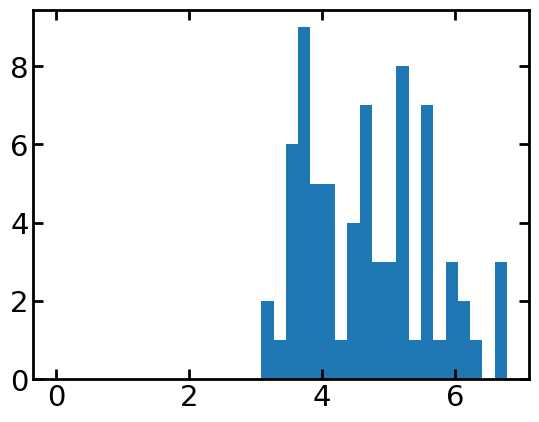

In [9]:
unique_narrow_cand = np.unique(srcidlist[(best_models == 2)])
cand_z = []
cand_compact = []
for i in range(len(unique_narrow_cand)):
    srcid = unique_narrow_cand[i]
    z = all_nirspec_beta_catalog['z'][all_nirspec_beta_catalog['uid'] == srcid][0]
    compact = all_nirspec_beta_catalog['compact'][all_nirspec_beta_catalog['uid'] == srcid][0]
    cand_z.append(z)
    cand_compact.append(compact)

cand_z = np.array(cand_z)
cand_compact = np.array(cand_compact)

_ = plt.hist(cand_z[cand_compact], bins=20)
_ = plt.hist(cand_z[~cand_compact], bins=20, alpha=0.5)

print(unique_narrow_cand[cand_compact])
print(cand_z[cand_compact])

In [10]:
print(len(np.unique(srcidlist)))
print(len(srcidlist))


491
624


In [11]:
broad_detection_BIC = BIC_Ha4 + 6 <= BIC_Ha3
no_broad_detection_BIC = BIC_Ha4  > BIC_Ha3 
# AIC_sel = np.where(AIC_Ha2  > AIC_Ha1 )

print('broad_detection sources:', np.unique(srcidlist[broad_detection_BIC]))
print(len(np.unique(srcidlist[broad_detection_BIC])))
print('no_broad_detection sources:', np.unique(srcidlist[no_broad_detection_BIC]))
print(len(np.unique(srcidlist[no_broad_detection_BIC])))
print('vague sources:', np.unique(srcidlist[~(broad_detection_BIC | no_broad_detection_BIC)]))
print(len(np.unique(srcidlist[~(broad_detection_BIC | no_broad_detection_BIC)])))

# narrowuidlist = [ 12329,  22015,  8219]
# narrowuidlist = [8219,12329,16321,20547,22015]
# 13890: likely a broad line
# 15226: no obvious Ha line detected
# 15265: no broad in high spectra, but broad in medium spectra
# 15500: too broad for single Gaussian, should be vague

# 9793, 12229: move to broad line
# 11344, 13890: to vague
# 15500: too broad for single Gaussian, should be vague

broad_detection sources: [ 6186  6553  7316  7622  7710  7749  7827  7845  7863  8004  8010  8208
  8217  8457  9048  9073  9346  9424  9464  9547  9793  9865  9887  9985
 10034 10520 10526 10585 11190 11389 12256 13374 13427 14666 14988 15076
 15257 15265 15294 15299 15557 15596 15619 18330 18547 19848 20412 20651
 20692 20969 21716 21722 21925 21992 22064]
55
no_broad_detection sources: [ 5684  5689  5775  5777  5780  5791  5812  5834  5852  5902  5907  6020
  6172  6174  6183  6192  6294  6295  6306  6376  6393  6399  6402  6409
  6426  6436  6451  6455  6520  6535  6544  6559  7301  7302  7318  7327
  7328  7330  7338  7341  7343  7362  7367  7368  7371  7421  7513  7525
  7591  7613  7615  7618  7623  7626  7631  7633  7638  7651  7662  7697
  7698  7708  7710  7712  7717  7721  7728  7733  7734  7757  7777  7780
  7791  7799  7801  7802  7805  7827  7887  8012  8018  8021  8029  8030
  8031  8033  8158  8174  8180  8186  8202  8209  8337  8357  8368  8413
  8414  8416  8418  8477

In [12]:
F444SNR = all_nirspec_beta_catalog['f_f444w']/all_nirspec_beta_catalog['e_f444w']
all_nirspec_beta_catalog_compact = all_nirspec_beta_catalog[(all_nirspec_beta_catalog['compact'] == True)*(F444SNR > 10)*(all_nirspec_beta_catalog['z'] > 2)] #

In [13]:
ID_broad_detect = np.append(np.unique(srcidlist[broad_detection_BIC]), [9793, 12229])
# Remove specific values from the unique list
ID_no_broad_detect = np.setdiff1d(np.unique(srcidlist[no_broad_detection_BIC]), [9793, 12229, 11344, 13890, 15500])
ID_no_broad_detect = np.append(ID_no_broad_detect, [8219])
ID_vague = np.append(np.unique(srcidlist[~(broad_detection_BIC | no_broad_detection_BIC)]), [11344, 13890, 15500])
ID_vague = np.setdiff1d(ID_vague, [8219,12329,16321,20547,22015])



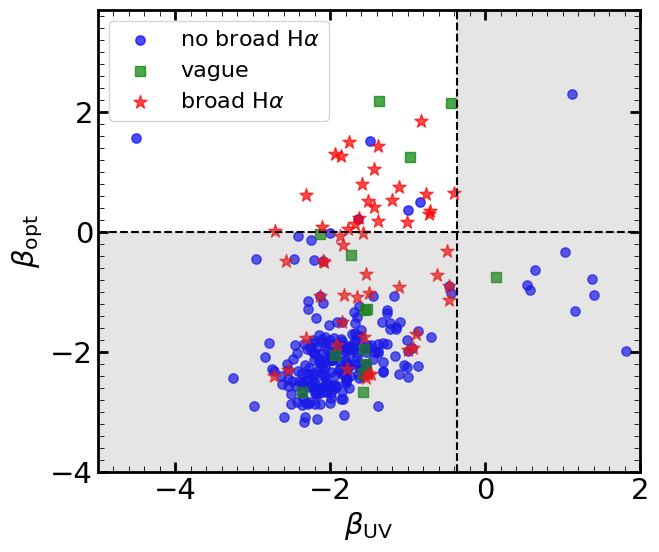

In [23]:
compact_uid = all_nirspec_beta_catalog_compact['uid'].value
ID_catagory = [ID_no_broad_detect, ID_vague, ID_broad_detect, ]
label = [r'no broad H$\alpha$', 'vague', r'broad H$\alpha$']
color = ['blue', 'green', 'red']
symbols = ['o', 's', '*']
size = [45, 45, 100]
fig = plt.figure(figsize=(7, 6))

for i in range(len(ID_catagory)):
    ID = ID_catagory[i]
    src_mask = np.isin(compact_uid, ID)
    compact_catalog = all_nirspec_beta_catalog_compact[src_mask]

    plt.scatter(compact_catalog['beta_UV'], compact_catalog['beta_opt'], label=label[i], alpha=0.7, s=size[i], color = color[i], marker = symbols[i])

plt.axhline(y=0, color='black', linestyle='--')
# ax.axvline(x=-2.8, color='black', linestyle='--')
plt.axvline(x=-0.37, color='black', linestyle='--')
# ax1.fill_between(x, -1, 1, where=(x <= -0.37), color='gray', alpha=0.3)
y = np.linspace(0, 10, 100)
plt.fill_betweenx(y, -0.37, 2, color='gray', alpha=0.2)
plt.fill_betweenx(-y, -8, 2, color='gray', alpha=0.2)

# set major locator
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(2))
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(0.2))
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.2))

plt.xlim(-5, 2)
plt.ylim(-4, 3.7)
plt.xlabel(r'$\beta_{\rm UV}$')
plt.ylabel(r'$\beta_{\rm opt}$')
plt.legend(fontsize = 16, loc = 0)

plt.savefig('../Figure/broadline_slope_relation.pdf', dpi=300)

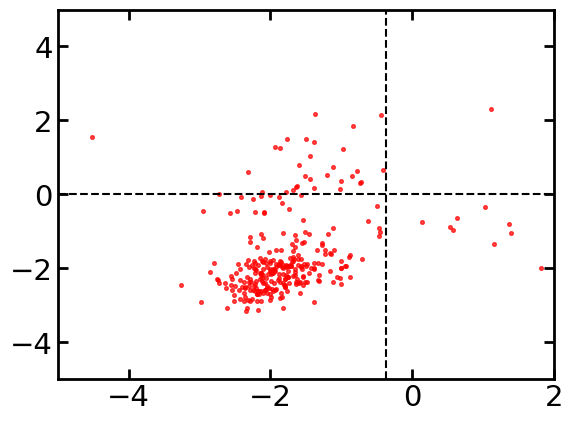

In [26]:
src_mask = np.isin(compact_uid, np.concatenate([ID_no_broad_detect, ID_vague, ID_broad_detect]))
compact_catalog = all_nirspec_beta_catalog_compact[src_mask]
lrd_mask = (compact_catalog['beta_UV'] < -0.37)*(compact_catalog['beta_opt'] > 0)

plt.scatter(compact_catalog['beta_UV'], compact_catalog['beta_opt'], label=label[i], alpha=0.7, s=7, color = color[i])
plt.xlim(-5, 2)
plt.ylim(-5, 5)
plt.axhline(y=0, color='black', linestyle='--')
# ax.axvline(x=-2.8, color='black', linestyle='--')
plt.axvline(x=-0.37, color='black', linestyle='--')

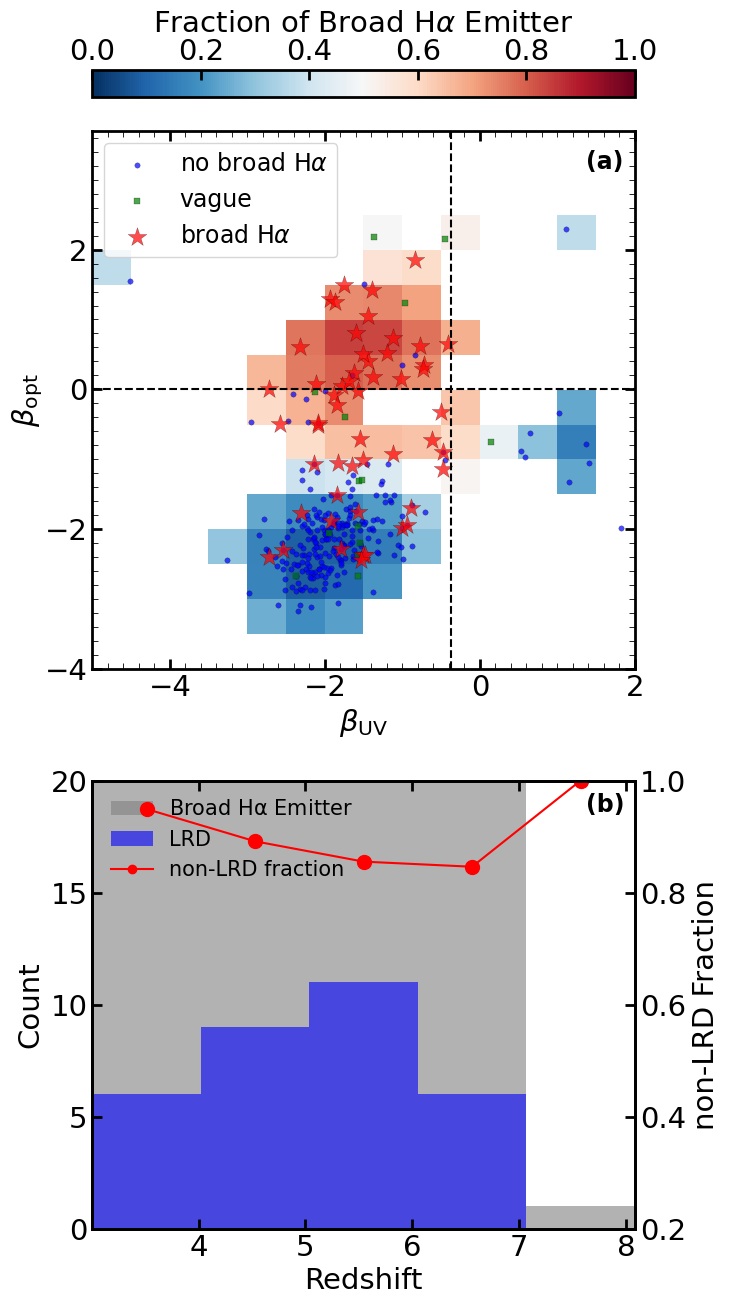

In [27]:
import numpy as np
import matplotlib.pyplot as plt
# ID_catagory = [ID_no_broad_detect, ID_vague, ID_broad_detect, ]
# 提取需要的数据
compact_uid = all_nirspec_beta_catalog_compact['uid'].value
ID_catagory = [ID_no_broad_detect, ID_vague, ID_broad_detect, ]
label = [r'no broad H$\alpha$', 'vague', r'broad H$\alpha$']
color = ['blue', 'green', 'red']
symbols = ['o', 's', '*']
size = [15, 15, 200]

beta_uv = all_nirspec_beta_catalog_compact['beta_UV'].value
beta_opt = all_nirspec_beta_catalog_compact['beta_opt'].value
uid = all_nirspec_beta_catalog_compact['uid'].value

# 创建掩码：哪些是 broad_detect，哪些是其它
is_broad = np.isin(uid, ID_broad_detect)
is_vague = np.isin(uid, ID_vague)
is_no_broad = np.isin(uid, ID_no_broad_detect)
# 定义网格划分参数
x_bins = np.arange(-5, 2.0, 0.5)
y_bins = np.arange(-4, 4, 0.5)
x_centers = (x_bins[:-1] + x_bins[1:]) / 2
y_centers = (y_bins[:-1] + y_bins[1:]) / 2

# 创建网格统计比例
grid_ratio = np.full((len(y_centers), len(x_centers)), np.nan)

for i in range(len(x_centers)):
    for j in range(len(y_centers)):
        x_min, x_max = x_bins[i], x_bins[i+1]
        y_min, y_max = y_bins[j], y_bins[j+1]

        # 找到在这个格子里的所有点
        in_box = (beta_uv >= x_min) & (beta_uv < x_max) & (beta_opt >= y_min) & (beta_opt < y_max)

        total = np.sum(in_box)
        if total >= 1:
            broad_in_box = np.sum(is_broad & in_box)
            vague_in_box = np.sum(is_vague & in_box)
            no_broad_in_box = np.sum(is_no_broad & in_box)

            grid_ratio[j, i] = (broad_in_box + 0.5*vague_in_box)/ (broad_in_box + vague_in_box + no_broad_in_box)

# 画图
# fig, ax = plt.subplots(figsize=(7, 9))
fig, axs = plt.subplots(figsize=(7, 16), ncols = 1, nrows=2, gridspec_kw={'height_ratios': [1.5, 1]})  # 例如上面是 3 倍高，下面是 1 倍高)
ax = axs[0]
from scipy.ndimage import gaussian_filter

grid_ratio_no_num = np.copy(grid_ratio)
np.nan_to_num(grid_ratio_no_num, nan=0.5, copy=False)
ratio_smooth = gaussian_filter(grid_ratio_no_num , sigma=1)
# set the ratio_smooth where grid_ratio is NaN to NaN
ratio_smooth[np.isnan(grid_ratio)] = np.nan


# 使用颜色图显示比例
im = ax.imshow(ratio_smooth, origin='lower', extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]],
               cmap='RdBu_r', vmin=0, vmax=1, aspect='auto')

# 添加 colorbar 水平方向 orientation='horizontal',放在上面
# cbar = plt.colorbar(im, ax=ax)
cbar = fig.colorbar(im, ax=ax, orientation='horizontal',location='top')
cbar.set_label(r'Fraction of Broad H$\alpha$ Emitter', fontsize=fontsize)
# cbar.ax.xaxis.set_ticks_position('top')  # Move the ticks to the top

# 画出散点（使用不同颜色编码）
for i in range(len(ID_catagory)):
    ID = ID_catagory[i]
    src_mask = np.isin(uid, ID)
    compact_catalog_ = all_nirspec_beta_catalog_compact[src_mask]
    ax.scatter(compact_catalog_['beta_UV'], compact_catalog_['beta_opt'],
               label=label[i], alpha=0.7, s=size[i], color=color[i], marker=symbols[i], edgecolor='k', linewidth=0.2)

# y = np.linspace(0, 10, 100)
# ax.fill_betweenx(y, -0.37, 2, color='gray', alpha=0.4)
# ax.fill_betweenx(-y, -8, 2, color='gray', alpha=0.4)
# 样式设置
ax.axhline(y=0, color='black', linestyle='--')
ax.axvline(x=-0.37, color='black', linestyle='--')
ax.set_xlim(-5, 2)
ax.set_ylim(-4, 3.7)
ax.set_xlabel(r'$\beta_{\rm UV}$')
ax.set_ylabel(r'$\beta_{\rm opt}$', labelpad = 0.0)
ax.legend(fontsize=17, loc='upper left')
ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.yaxis.set_major_locator(plt.MultipleLocator(2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.2))
ax.text(0.91, 0.93, '(a)', fontsize=17, transform=ax.transAxes, color='black', weight='bold')

ax1 = axs[1]

# 设置 bins
bins = np.linspace(min(compact_catalog['z']), max(compact_catalog['z']), 6)

# 主数据和 LRD 数据的直方图计数
counts_all, bin_edges = np.histogram(compact_catalog['z'], bins=bins)
counts_lrd, _ = np.histogram(compact_catalog[lrd_mask]['z'], bins=bins)

# 计算每个 bin 中的 LRD 占比
ratios = counts_lrd / counts_all
ratios[counts_all == 0] = np.nan  # 避免除以0

# 计算 bin 中心
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# 左 y 轴：绘制直方图
ax1.hist(compact_catalog['z'], bins=bins, alpha=0.6, color='gray', label=r'$\rm Broad~H\alpha~Emitter$')
ax1.hist(compact_catalog['z'][lrd_mask], bins=bins, alpha=0.6, color='blue', label='LRD')
ax1.set_xlabel('Redshift')
ax1.set_ylabel('Count')
ax1.set_xlim(bins[0], bins[-1])
ax1.set_ylim(0,20)
ax1.plot([], [], marker='o', linestyle='-', color='red', label='non-LRD fraction')
ax1.text(0.91, 0.93, '(b)', fontsize=17, transform=ax1.transAxes, color='black', weight='bold')
# 右 y 轴：绘制比例曲线和散点
ax2 = ax1.twinx()
ax2.plot(bin_centers, 1 - ratios, marker='o', linestyle='-', color='red', markersize = 10)
ax2.set_ylabel('non-LRD Fraction')
ax2.set_ylim(0.2, 1.0)  # 可以根据比例调整上下限

# 图例
ax1.legend(loc='upper left', ncols = 1, fontsize = 15, frameon=False)
# ax2.legend(loc='upper right')

# plt.tight_layout()



plt.savefig('/Users/zijianzhang/Astro_Data/LRD_SPEC/Figure/broadline_slope_relation.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [31]:
print(len(np.unique(srcidlist)))
print(len(srcidlist))


491
624


In [32]:
src_mask = np.isin(uid, ID_broad_detect)
lrd_mask = (compact_catalog['beta_UV'] < -0.37)*(compact_catalog['beta_opt'] > 0)
compact_catalog = all_nirspec_beta_catalog_compact[is_broad]
print(len(compact_catalog))
print(len(compact_catalog[lrd_mask]))

55
24


In [33]:
bins

array([3.09 , 3.824, 4.558, 5.292, 6.026, 6.76 ])

In [34]:
print(len(all_nirspec_beta_catalog_compact[is_broad]))
print(len(all_nirspec_beta_catalog_compact[is_vague]))
print(len(all_nirspec_beta_catalog_compact[is_no_broad]))

print(len(all_nirspec_beta_catalog_compact[is_broad]) + len(all_nirspec_beta_catalog_compact[is_vague]) + len(all_nirspec_beta_catalog_compact[is_no_broad]))

55
15
256
326


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from loess.loess_2d import loess_2d
from matplotlib.colors import Normalize

# 准备数据
beta_uv = all_nirspec_beta_catalog_compact['beta_UV'].value
beta_opt = all_nirspec_beta_catalog_compact['beta_opt'].value
uid = all_nirspec_beta_catalog_compact['uid'].value
is_broad = np.isin(uid, ID_broad_detect).astype(float)
is_vague = np.isin(uid, ID_vague).astype(float)

# 去除无效值
valid = (beta_uv < 2)*(beta_uv > -5)*(beta_opt < 3.7)*(beta_opt > -4) #* (np.isfinite(x) & np.isfinite(y) & np.isfinite(z))
x = beta_uv[valid]
y = beta_opt[valid]
z = is_broad[valid]
z[is_vague[valid] == 1] = 0.5  # vague sources标记为0.5

# 设置平滑网格（可改为更高分辨率）
xgrid = np.linspace(-5, 2, 5)
ygrid = np.linspace(-4, 3.7, 5)
xnew, ynew = np.meshgrid(xgrid, ygrid)
xnew_flat = xnew.ravel()
ynew_flat = ynew.ravel()

# LOESS 平滑
z_smooth, weights = loess_2d(x, y, z, xnew_flat, ynew_flat, degree=1, frac=0.5)

# 重塑为网格
Zgrid = z_smooth.reshape(xnew.shape)

# 绘图
fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(Zgrid, extent=[-5, 2, -4, 3.7], origin='lower',
               cmap='RdBu_r', vmin=0, vmax=1, aspect='auto')

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Fraction of Broad Hα (LOESS Smoothed)')

# 原始点图层
for i in range(len(ID_catagory)):
    ID = ID_catagory[i]
    src_mask = np.isin(uid, ID)
    compact_catalog = all_nirspec_beta_catalog_compact[src_mask]
    ax.scatter(compact_catalog['beta_UV'], compact_catalog['beta_opt'],
               label=label[i], alpha=0.6, s=size[i], color=color[i],
               marker=symbols[i], edgecolor='k', linewidth=0.2)

# 辅助线与格式
ax.axhline(y=0, color='black', linestyle='--')
ax.axvline(x=-0.37, color='black', linestyle='--')
ax.set_xlim(-5, 2)
ax.set_ylim(-4, 3.7)
ax.set_xlabel(r'$\beta_{\rm UV}$')
ax.set_ylabel(r'$\beta_{\rm opt}$')
ax.legend(fontsize=12, loc='upper left')
ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.yaxis.set_major_locator(plt.MultipleLocator(2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.2))

 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


LinAlgError: SVD did not converge in Linear Least Squares

Text(0.5, 1.0, 'Broad Hα Fraction (Smoothed)')

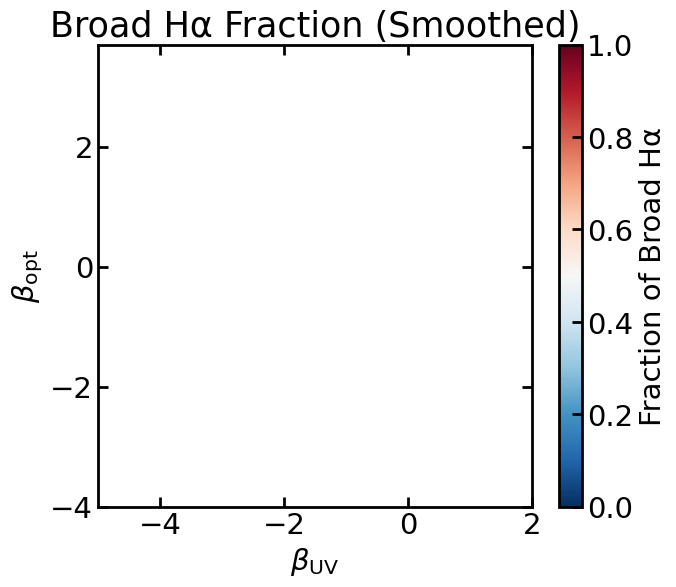

In [36]:
# 用当前 compact_catalog（scatter 中的点）为基础来构建 z
uids = compact_catalog['uid']
z = np.array([1 if uid in ID_broad_detect else 0 for uid in uids])

# 然后做 histogram 分箱
x = compact_catalog['beta_UV']
y = compact_catalog['beta_opt']

xbins = np.linspace(-5, 2, 100)
ybins = np.linspace(-4, 3.7, 100)

H_total, _, _ = np.histogram2d(x, y, bins=[xbins, ybins])
H_broad, _, _ = np.histogram2d(x[z > 0], y[z > 0], bins=[xbins, ybins], weights=z[z > 0])

# 避免除以0
with np.errstate(divide='ignore', invalid='ignore'):
    ratio = H_broad / H_total
    ratio[H_total < 10] = np.nan  # 可调的下限

from scipy.ndimage import gaussian_filter
ratio_smooth = gaussian_filter(ratio, sigma=1)

# 可视化
plt.figure(figsize=(7,6))
plt.imshow(ratio_smooth.T, origin='lower',
           extent=[xbins.min(), xbins.max(), ybins.min(), ybins.max()],
           cmap='RdBu_r', vmin=0, vmax=1, aspect='auto')
plt.colorbar(label='Fraction of Broad Hα')
plt.xlabel(r'$\beta_{\rm UV}$')
plt.ylabel(r'$\beta_{\rm opt}$')
plt.title('Broad Hα Fraction (Smoothed)')